## Assignment 3


In [124]:
## Assignment 1, Part 1 – Transformations for Normalized Power
## Based on Lecture 4 (Example 4.16) and assignment equations (1) & (2)

# ---------------------------------------------------------------
# 1. Load and normalize data
# ---------------------------------------------------------------
df_tuno <- read.table("data/tuno.txt", header = TRUE)
df_tuno$pow.obs <- df_tuno$pow.obs / 5000        # normalize to (0,1)
y <- df_tuno$pow.obs

### 1) Extract the residuals from the linear model given above, and construct
the matrix

In [125]:
y <- df_tuno$pow.obs   # original data (positive, scaled if needed)
n <- length(y)

# --- Assignment transformation (1)
# y(λ) = (1/λ) * log( y^λ / (1 - y^λ) )
boxcox <- function(lambda, y) {
  (1 / lambda) * log((y^lambda) / (1 - y^lambda))
}

y_trans <- boxcox(0.2, y)
ws_trans <- log(df_tuno$ws30)

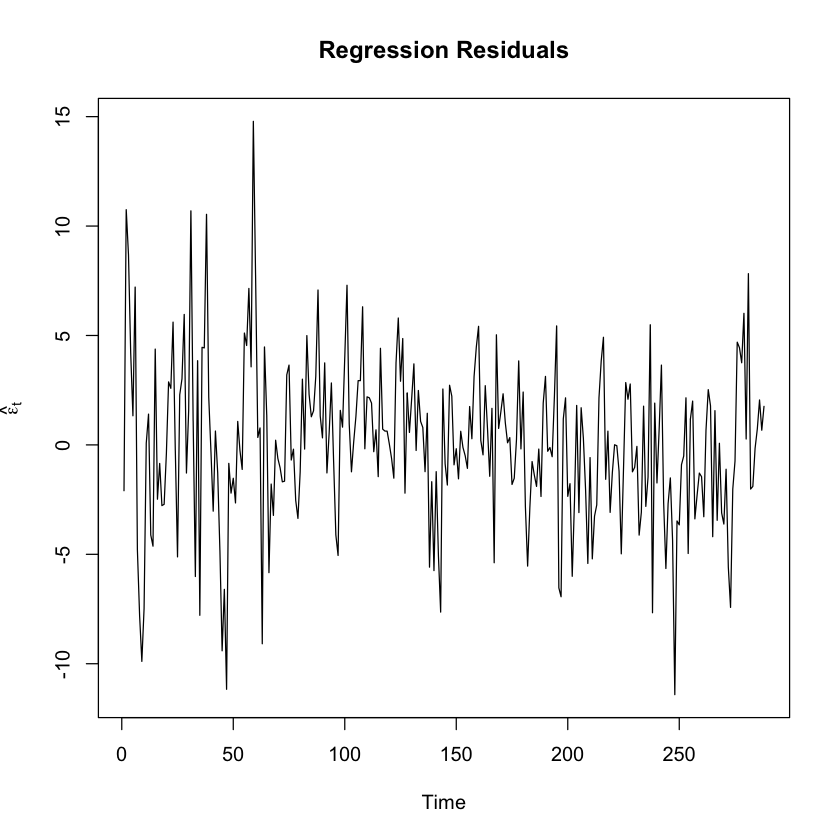

In [126]:
fit <- lm(y_trans ~ ws_trans + I(ws_trans^2))
e <- residuals(fit)
E <- cbind(e[-length(e)], e[-1])
colnames(E) <- c("e_t", "e_t_plus_1")


par(bg = "white")

plot(e, type = "l",
     main = "Regression Residuals",
     ylab = expression(hat(epsilon)[t]),
     xlab = "Time")


### 2. Fit parameters in the model

$$
[\mathbf{e}_i, \mathbf{e}_{i+1}]^T \sim N(\mathbf{0}, \mathbf{\Sigma}), \quad \text{with}
$$
$$
\mathbf{\Sigma} = \sigma^2
\begin{pmatrix}
1 & \rho \\
\rho & 1
\end{pmatrix}
\quad (5)
$$


#### Log-likelihood

In [127]:
# E is the matrix from Task 1:
library(numDeriv)
nll <- function(par, E) {
  sigma2 <- exp(par[1])        # log-transform to enforce positivity
  rho    <- tanh(par[2])       # Fisher z-transform to keep |rho|<1
  
  S <- sigma2 * matrix(c(1, rho, rho, 1), 2, 2)
  Sinv <- solve(S)
  logdet <- log(det(S))
  
  ll <- 0
  for (i in 1:nrow(E)) {
    ll <- ll + t(E[i, ]) %*% Sinv %*% E[i, ]
  }
  0.5 * (nrow(E) * logdet + ll)
}


#### MLE

In [128]:
opt <- nlminb(c(log(var(E)), atanh(0)),
              nll, E = E)

sigma2_hat <- exp(opt$par[1])
rho_hat    <- tanh(opt$par[2])
c(sigma2_hat = sigma2_hat, rho_hat = rho_hat)


sigma2_hat    rho_hat 
14.0378178  0.3234813

#### Wald confidence

In [129]:
library(MASS)

H <- hessian(nll, opt$par, E = E)
V <- ginv(H)

se_logsigma2 <- sqrt(V[1,1])
se_zrho      <- sqrt(V[2,2])

CI_sigma2 <- sigma2_hat * exp(c(-1,1) * qnorm(0.975) * se_logsigma2)
CI_rho    <- tanh(atanh(rho_hat) + c(-1,1) * qnorm(0.975) * se_zrho)

CI_sigma2
CI_rho


[1] 12.43058 15.85287

[1] 0.2163631 0.4229041

#### Wald-Test

In [130]:
W <- (atanh(rho_hat) / se_zrho)^2
p_wald <- 1 - pchisq(W, df = 1)
p_wald


[1] 1.313918e-08

#### Likelihood Ratio test

In [131]:
nll0 <- function(par, E) {
  sigma2 <- exp(par)
  S <- sigma2 * diag(2)
  Sinv <- solve(S)
  logdet <- log(det(S))
  
  ll <- 0
  for (i in 1:nrow(E)) {
    ll <- ll + t(E[i, ]) %*% Sinv %*% E[i, ]
  }
  0.5 * (nrow(E) * logdet + ll)
}

opt0 <- nlminb(log(var(E)), nll0, E = E)

LR <- 2 * (opt0$objective - opt$objective)
p_lr <- 1 - pchisq(LR, df = 1)

p_lr


[1] 1.778985e-08

#### Contour plot

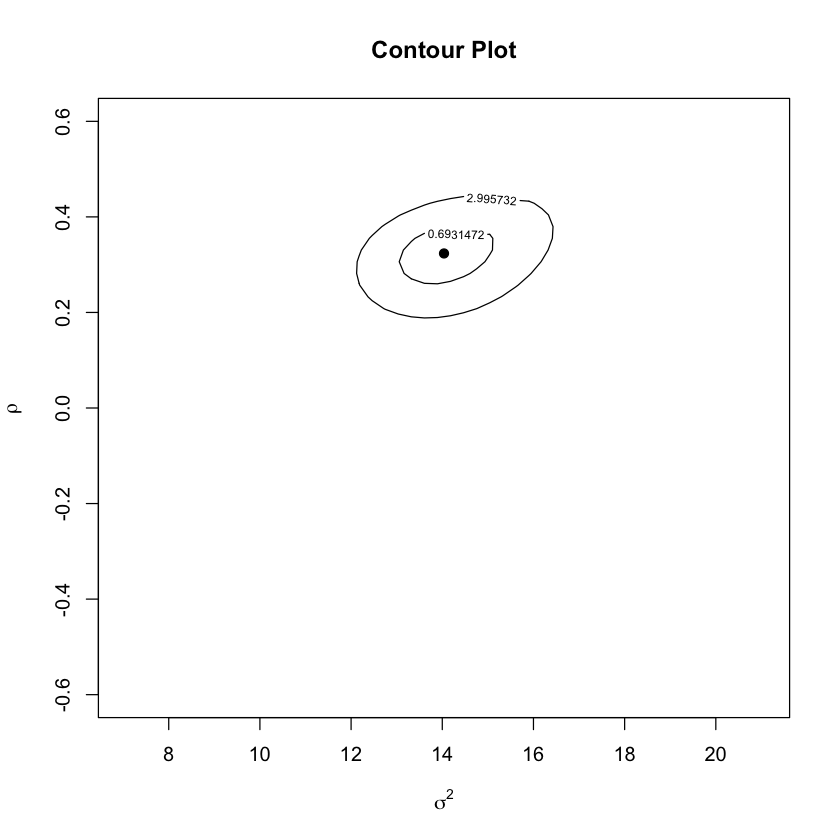

In [132]:
sigma2_seq <- seq(0.5 * sigma2_hat, 1.5 * sigma2_hat, length = 50)
rho_seq    <- seq(-0.6, 0.6, length = 50)

LL <- outer(sigma2_seq, rho_seq,
            Vectorize(function(s2, r) {
              nll(c(log(s2), atanh(r)), E)
            }))

LL <- LL - min(LL)
par(bg = "white")

contour(sigma2_seq, rho_seq, LL,
        main = "Contour Plot",
        levels = qchisq(c(0.5, 0.95), df = 2)/2,
        xlab = expression(sigma^2),
        ylab = expression(rho))
points(sigma2_hat, rho_hat, pch = 19)


### Task 3)

In [133]:
# Sample size (number of bivariate observations)
n <- nrow(E)

# Covariance matrix Sigma
Sigma <- sigma2_hat * matrix(c(1, rho_hat,
                               rho_hat, 1), 2, 2)

# Inverse of Sigma
Sigma_inv <- solve(Sigma)

# Derivatives of Sigma
dSigma_dsigma2 <- matrix(c(1, rho_hat,
                           rho_hat, 1), 2, 2)

dSigma_drho <- sigma2_hat * matrix(c(0, 1,
                                     1, 0), 2, 2)

# Fisher information entries using trace formula
I11 <- n/2 * sum(diag(Sigma_inv %*% dSigma_dsigma2 %*%
                      Sigma_inv %*% dSigma_dsigma2))

I12 <- n/2 * sum(diag(Sigma_inv %*% dSigma_dsigma2 %*%
                      Sigma_inv %*% dSigma_drho))

I22 <- n/2 * sum(diag(Sigma_inv %*% dSigma_drho %*%
                      Sigma_inv %*% dSigma_drho))

# Fisher information matrix
I_fisher <- matrix(c(I11, I12,
                     I12, I22), 2, 2)

colnames(I_fisher) <- rownames(I_fisher) <- c("sigma2", "rho")

I_fisher


,sigma2,rho
sigma2,1.456407,-7.386418
rho,-7.386418,395.464491


### Task 4)

#### Profile likelihood for $\rho$

In [134]:
profile_rho <- function(rho, E) {
  opt <- optimize(
    f = function(logsigma2) {
      par <- c(logsigma2, atanh(rho))
      nll(par, E)
    },
    interval = c(log(1e-4), log(1e4))
  )
  -opt$objective
}

rho_grid <- seq(-0.9, 0.9, length = 200)

lp_rho <- sapply(rho_grid, profile_rho, E = E)

lp_rho <- lp_rho - max(lp_rho)   # normalize


#### Quadratic Wald

In [135]:
I_rho <- I_fisher["rho", "rho"]
quad_rho <- -0.5 * I_rho * (rho_grid - rho_hat)^2


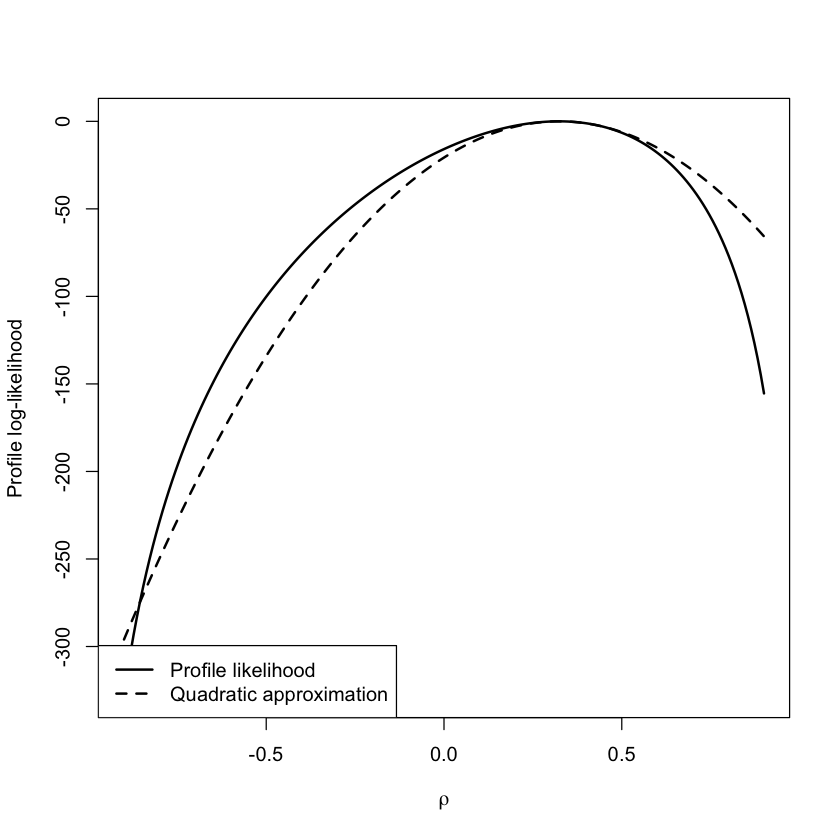

In [136]:
par(bg = "white")

plot(rho_grid, lp_rho, type = "l", lwd = 2,
     xlab = expression(rho),
     ylab = "Profile log-likelihood")

lines(rho_grid, quad_rho, lty = 2, lwd = 2)
legend("bottomleft",
       legend = c("Profile likelihood", "Quadratic approximation"),
       lty = c(1,2), lwd = 2)


#### Fisher’s z-transform for ρ (Exercise 3.23)

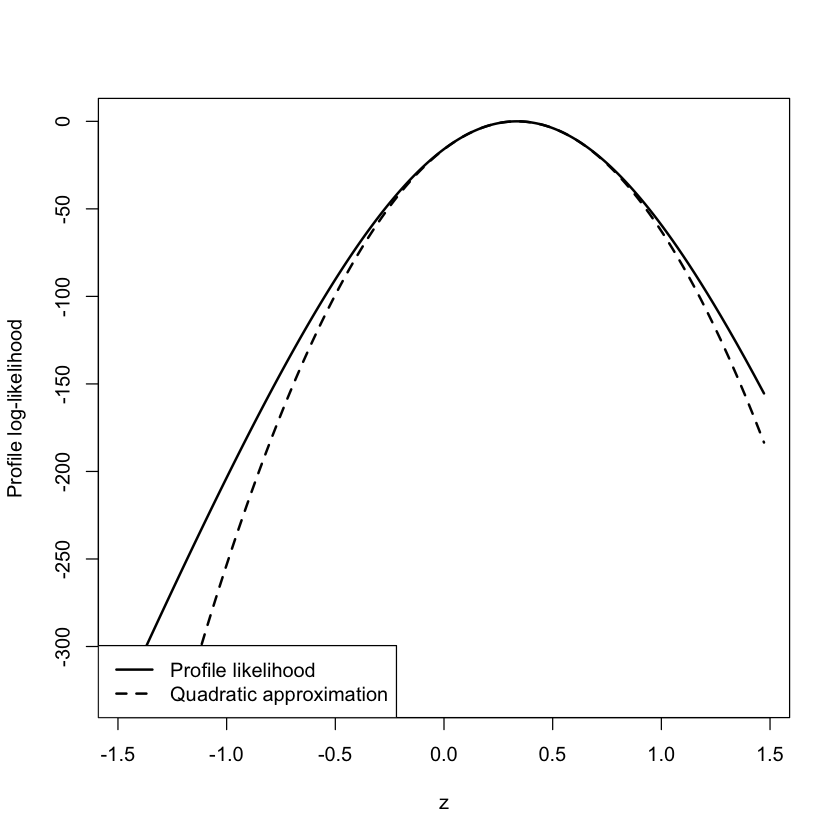

In [137]:
par(bg = "white")

z_grid <- 0.5 * log((1 + rho_grid)/(1 - rho_grid))
lp_z <- lp_rho
z_hat <- 0.5 * log((1 + rho_hat)/(1 - rho_hat))
I_z <- 1 / (nrow(E) - 3)   # Exercise 3.23

quad_z <- -0.5 * (z_grid - z_hat)^2 / I_z
plot(z_grid, lp_z, type = "l", lwd = 2,
     xlab = "z",
     ylab = "Profile log-likelihood")

lines(z_grid, quad_z, lty = 2, lwd = 2)
legend("bottomleft",
       legend = c("Profile likelihood", "Quadratic approximation"),
       lty = c(1,2), lwd = 2)


#### Profile likelihood for σ² and log(σ²)

In [138]:
profile_sigma2 <- function(sigma2, E) {
  opt <- optimize(
    f = function(rho_z) {
      par <- c(log(sigma2), rho_z)
      nll(par, E)
    },
    interval = c(-5, 5)
  )
  -opt$objective
}
sigma2_grid <- seq(0.5 * sigma2_hat, 1.5 * sigma2_hat, length = 200)
lp_sigma2 <- sapply(sigma2_grid, profile_sigma2, E = E)
lp_sigma2 <- lp_sigma2 - max(lp_sigma2)

eta_grid <- log(sigma2_grid)

I_eta <- I_fisher["sigma2","sigma2"] * sigma2_hat^2
quad_eta <- -0.5 * I_eta * (eta_grid - log(sigma2_hat))^2



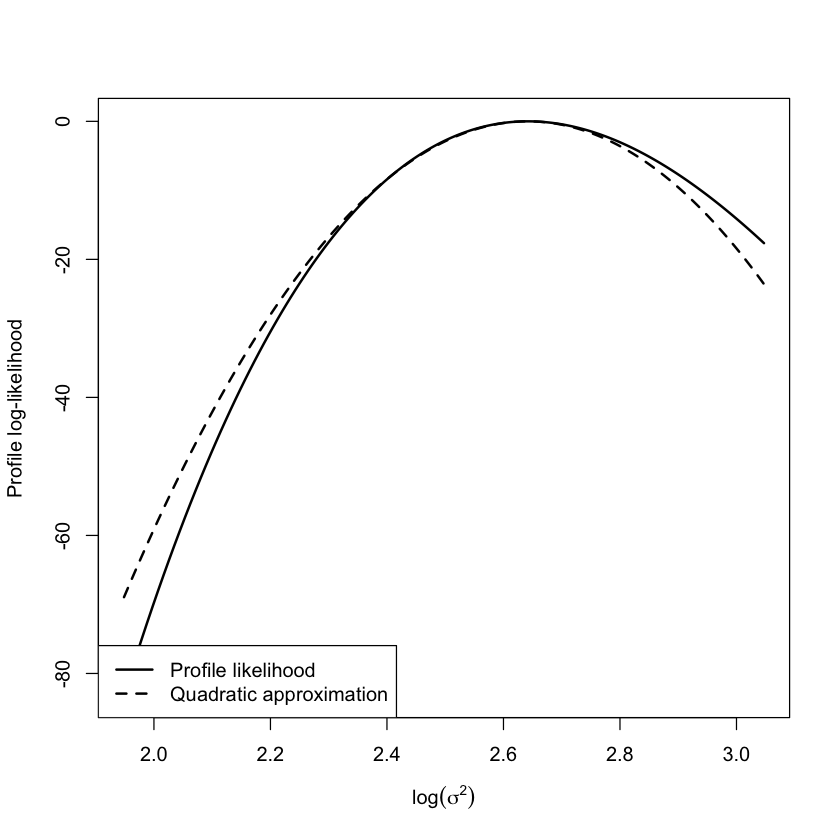

In [140]:
par(bg = "white")

plot(eta_grid, lp_sigma2, type = "l", lwd = 2,
     xlab = expression(log(sigma^2)),
     ylab = "Profile log-likelihood")

lines(eta_grid, quad_eta, lty = 2, lwd = 2)
legend("bottomleft",
       legend = c("Profile likelihood", "Quadratic approximation"),
       lty = c(1,2), lwd = 2)


### Task 5

In [141]:
# Create lagged residuals
e_lag <- e[-length(e)]
e_now <- e[-1]

# Conditional MLE for phi
phi_cond <- sum(e_now * e_lag) / sum(e_lag^2)

# Conditional MLE for sigma_u^2
sigma2_u_cond <- mean((e_now - phi_cond * e_lag)^2)

c(phi_cond = phi_cond,
  sigma2_u_cond = sigma2_u_cond)


phi_cond sigma2_u_cond 
    0.3234297    12.5668948

In [ ]:
nll_ar1_full <- function(par, e) {
  phi      <- tanh(par[1])        # ensures |phi| < 1
  sigma2_u <- exp(par[2])         # ensures sigma^2 > 0
  
  # Conditional part
  res <- e[-1] - phi * e[-length(e)]
  ll_cond <- sum(dnorm(res, mean = 0, sd = sqrt(sigma2_u), log = TRUE))
  
  # Marginal part for e1 (stationary)
  ll_init <- dnorm(e[1],
                   mean = 0,
                   sd = sqrt(sigma2_u / (1 - phi^2)),
                   log = TRUE)
  
  -(ll_init + ll_cond)
}

In [143]:
opt_full <- optim(
  par = c(atanh(phi_cond), log(sigma2_u_cond)),
  fn  = nll_ar1_full,
  e   = e,
  hessian = TRUE
)

phi_full      <- tanh(opt_full$par[1])
sigma2_u_full <- exp(opt_full$par[2])

c(phi_full = phi_full,
  sigma2_u_full = sigma2_u_full)


phi_full sigma2_u_full 
    0.3228009    12.5347119

In [144]:
# Implied marginal variance from AR(1)
sigma2_marginal <- sigma2_u_full / (1 - phi_full^2)

c(phi_full = phi_full,
  sigma2_marginal = sigma2_marginal)


phi_full sigma2_marginal 
      0.3228009      13.9927641

### Task 6)

In [145]:
fit <- lm(y_trans ~ ws_trans + I(ws_trans^2))


In [146]:
fit_lm <- lm(y_trans ~ ws_trans + I(ws_trans^2))

logLik(fit_lm)


'log Lik.' -788.6998 (df=4)

In [147]:
library(nlme)

fit_ar1 <- gls(
  y_trans ~ ws_trans + I(ws_trans^2),
  correlation = corAR1(form = ~ 1),
  method = "ML"
)

logLik(fit_ar1)


'log Lik.' -772.505 (df=5)

In [148]:
logLik(fit_lm)
logLik(fit_ar1)


'log Lik.' -788.6998 (df=4)

'log Lik.' -772.505 (df=5)

In [149]:
LR <- 2 * (logLik(fit_ar1) - logLik(fit_lm))
LR


'log Lik.' 32.38961 (df=5)

In [150]:
intervals(fit_ar1)$corStruct


,lower,est.,upper
Phi,0.2149346,0.3286891,0.4336445
